In [19]:
import numpy as np
from scipy.linalg import eigh
import random

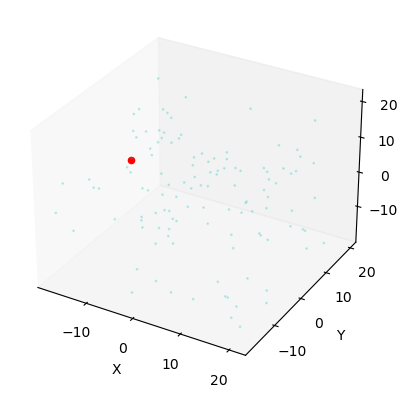

In [23]:
def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

#Randomly place 13C and electrons in lattice
R = FCC_lattice(3.57,5)

prob_C = 1.1*1e-2
prob_e = 100*1e-6
specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
carbons = random.sample(specials, int(len(R)*prob_C))
electrons = [pt for pt in specials if pt not in carbons]

S = np.zeros(R.shape)
T = np.zeros(R.shape)
for pos in carbons:
    S[pos,:] = R[pos,:]
for pos in electrons:
    T[pos,:] = R[pos,:]
    
carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
carbon_pts = np.array(carbon_pts)

e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
e_pts = np.array(e_pts)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

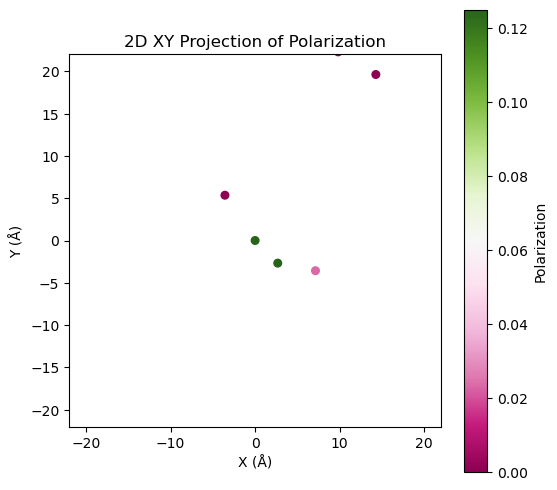

In [625]:
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T
r3 = 16*1e-10 #spin diffusion barrier radius

def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)


def place_specials(size):
    R = FCC_lattice(3.57,size)

    prob_C = 0.1*1e-2
    prob_e = 100*1e-6
    specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
    carbons = random.sample(specials, int(len(R)*prob_C))
    electrons = [pt for pt in specials if pt not in carbons]

    S = np.zeros(R.shape)
    T = np.zeros(R.shape)
    for pos in carbons:
        S[pos,:] = R[pos,:]
    for pos in electrons:
        T[pos,:] = R[pos,:]

    carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
    carbon_pts = np.array(carbon_pts)

    e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
    e_pts = np.array(e_pts)

    return carbon_pts, e_pts



def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])



def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

    N_carbon = carbon_pts.shape[0]
    N_e = e_pts.shape[0]
    N_bulk = outside_pts.shape[0]
    N_core = inside_pts.shape[0]

    distances = np.sum(outside_pts**2, axis=1)
    min_index = np.argmin(distances)
    closest_pt = outside_pts[min_index]
    shifted_pts = outside_pts - np.array(closest_pt)

    #Calculate W matrix
    from scipy.spatial import cKDTree

    threshold = 20
    tree = cKDTree(shifted_pts)
    pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

    W = np.zeros((N_bulk, N_bulk))
    for i, j in pairs:
        diff = shifted_pts[i] - shifted_pts[j]
        dist = np.linalg.norm(diff)
        unit_vec = diff / dist
        angle = np.arccos(unit_vec[2])

        A = 1 - 3 * (np.cos(angle))**2
        B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
        W[i, j] = 0.5 * B**2 * tau_d
        W[j, i] = 0.5 * B**2 * tau_d# symmetry

    W = W - np.diag(np.sum(W, axis=0))

    M = W
    return N_bulk, M, shifted_pts, min_index


def solve_ode(N_bulk, time, alpha_0, M):
    t_pts = len(time)
    alpha = np.zeros((N_bulk, t_pts))

    evals, evecs = eigh(M)
    V_inv = np.linalg.inv(evecs)

    # max_exp = 1000
    # evals_clipped = np.clip(evals, -max_exp, max_exp)

    V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
    for t in range(t_pts):
        alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

    return alpha


def calculate_mean_squared_distance(alpha, points, time):
    squared_distances = np.sum(points**2, axis=1)
    weighted_squares = alpha[:,time] * squared_distances
    mean_squared_distance = np.mean(weighted_squares)
    return mean_squared_distance

size = 5
t_pts = 100
T = np.linspace(0,5e-3,t_pts)
P = np.zeros(len(T))
carbon_pts, e_pts = place_specials(size)
N_bulk, M, shifted_pts, min_index = calculate_M(carbon_pts, e_pts, 1, 1)
alpha_0 = np.zeros(N_bulk)
alpha_0[min_index] = 1
alpha = solve_ode(N_bulk, T, alpha_0, M)

final_alpha = alpha[:, -1]

D = np.zeros(t_pts)
for t in range(t_pts):
    D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)

# fig = plt.figure()
# plt.plot(T, D, color='b')
# plt.xlabel('time (s)')
# plt.ylabel('mean squared displacement')
# plt.show()
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# p = ax.scatter(shifted_pts[:, 0], shifted_pts[:, 1], shifted_pts[:, 2],
#                c=final_alpha, cmap='bwr_r', s=20, alpha=0.9, vmin=0, vmax=1/N_bulk)
# fig.colorbar(p, label='Polarization (final)')
# ax.set_title('3D Polarization Heatmap')
# ax.set_xlabel('X (Å)')
# ax.set_ylabel('Y (Å)')
# ax.set_zlabel('Z (Å)')
# # ax.set_xlim([-25, 25])
# # ax.set_ylim([-25, 25])
# # ax.set_zlim([-25, 25])
# ax.grid(False)
# plt.tight_layout()
# plt.show()


fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(shifted_pts[:, 0], shifted_pts[:, 1], 
                c=final_alpha, cmap='PiYG', s=30, vmin=0, vmax=1/N_bulk)

ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_xlim([-22, 22])
ax.set_ylim([-22, 22])
ax.set_title('2D XY Projection of Polarization')
ax.set_aspect('equal')
ax.grid(False)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Polarization')
plt.show()


In [611]:
fig.savefig("C:\\Users\\Suber\\Desktop\\0.1%Diffusion.eps", format='eps', dpi=300)